# Tutorial-1: Integrating RNA+ADT Single-Cell Data Using MIDAS
In this tutorial, we illustrate the process of integrating multi-modal single-cell data using MIDAS across various batches. To begin quickly, we will utilize data from the first three batches of the "WNN" datasets. We will manually construct a combined mosaic of modalities for integration.

## Data Downloading & Pre-processing
In this tutorial, we use a CITE-seq PBMC dataset named WNN. We offer [pre-processed data](https://drive.google.com/drive/folders/1j3hDl2p4v3s0r5a-ktfHqbIhHbIPpUbS?usp=drive_link) to save time. Meanwhile, labels are provided as well. 

If processing from raw data is preferred, follow these steps:

1. Fetch the [raw data](https://atlas.fredhutch.org/nygc/multimodal-pbmc/).

2. Run ``bash ./data/prep_wnn.sh``

In [1]:
import warnings
warnings.filterwarnings('ignore')

from scmidas.datasets import GenDataFromPath

In [3]:
# These data has been pre-processed.
data_path = [
    {"rna": "./data/processed/wnn_demo/subset_0/mat/rna.csv", 
     "adt": "./data/processed/wnn_demo/subset_0/mat/adt.csv"},
    {"rna": "./data/processed/wnn_demo/subset_1/mat/rna.csv"},
    {"adt": "./data/processed/wnn_demo/subset_2/mat/adt.csv"},
]
save_dir = "./data/processed/wnn_demo/"
remove_old = False
GenDataFromPath(data_path, save_dir, remove_old) # generate a directory, can be substituted by preprocess/split_mat.py

Spliting rna matrix: 6378 cells, 4054 features


100%|██████████| 6378/6378 [00:10<00:00, 581.46it/s]


Spliting adt matrix: 6378 cells, 224 features


100%|██████████| 6378/6378 [00:04<00:00, 1459.02it/s]


Spliting rna matrix: 5899 cells, 4054 features


100%|██████████| 5899/5899 [00:10<00:00, 589.80it/s]


Spliting adt matrix: 4628 cells, 224 features


100%|██████████| 4628/4628 [00:03<00:00, 1518.30it/s]


## Integrating with MIDAS

In [4]:
from scmidas.models import MIDAS
from scmidas.datasets import GetDataInfo
import scanpy as sc
import pandas as pd
sc.set_figure_params(figsize=(4, 4))

### Initializing Model
We manually set "mods" to define a combination of modalities. If "mods" is not specified, all available modalities will be used for training.

In [5]:
task = "wnn_demo"
data = [GetDataInfo(f'./data/processed/{task}')]  # Support integration of multiple GetDataInfo objects with different features.

3 subset(s) in this path {'rna': 4054, 'adt': 224}
  subset_0 :  6378 cells ; ['rna', 'adt']
  subset_1 :  5899 cells ; ['rna']
  subset_2 :  4628 cells ; ['adt']


### Training
The function .init_model can accept parameters for customizing the model structure. Here, we utilize the default model structure.

In [6]:
model = MIDAS(data)
model.init_model()
model.train(n_epoch=500, save_path=f'./result/{task}/train/')

Parameter number: 9.092 M
Training ...


Loss: 1383.3590: 100%|██████████| 500/500 [1:08:46<00:00,  8.25s/it]


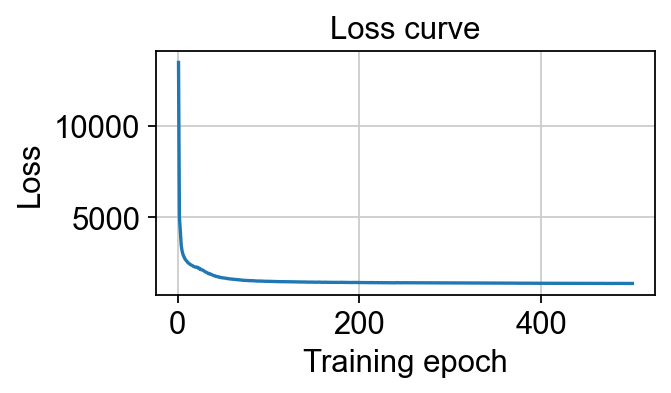

In [7]:
model.viz_loss()

### Inference
We support predicting various types of outputs, including embeddings and corrected counts. Here, we demonstrate how to retrieve embeddings.

In [8]:
model.predict(save_dir=f'./result/{task}/predict/')

Predicting ...
Removing directory "./result/wnn_demo/predict/subset_1/z"
Removing directory "./result/wnn_demo/predict/subset_2/z"
Removing directory "./result/wnn_demo/predict/subset_0/z"
Processing subset 0: ['rna', 'adt']


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Processing subset 1: ['rna']


100%|██████████| 24/24 [00:04<00:00,  4.87it/s]


Processing subset 2: ['adt']


100%|██████████| 19/19 [00:05<00:00,  3.71it/s]


## Visualization

### Joint Embeddings

In [9]:
emb = model.read_preds()

Loading predicted variables ...


100%|██████████| 19/19 [00:00<00:00, 36.77it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Converting subset 2: s, joint
Converting subset 2: z, joint


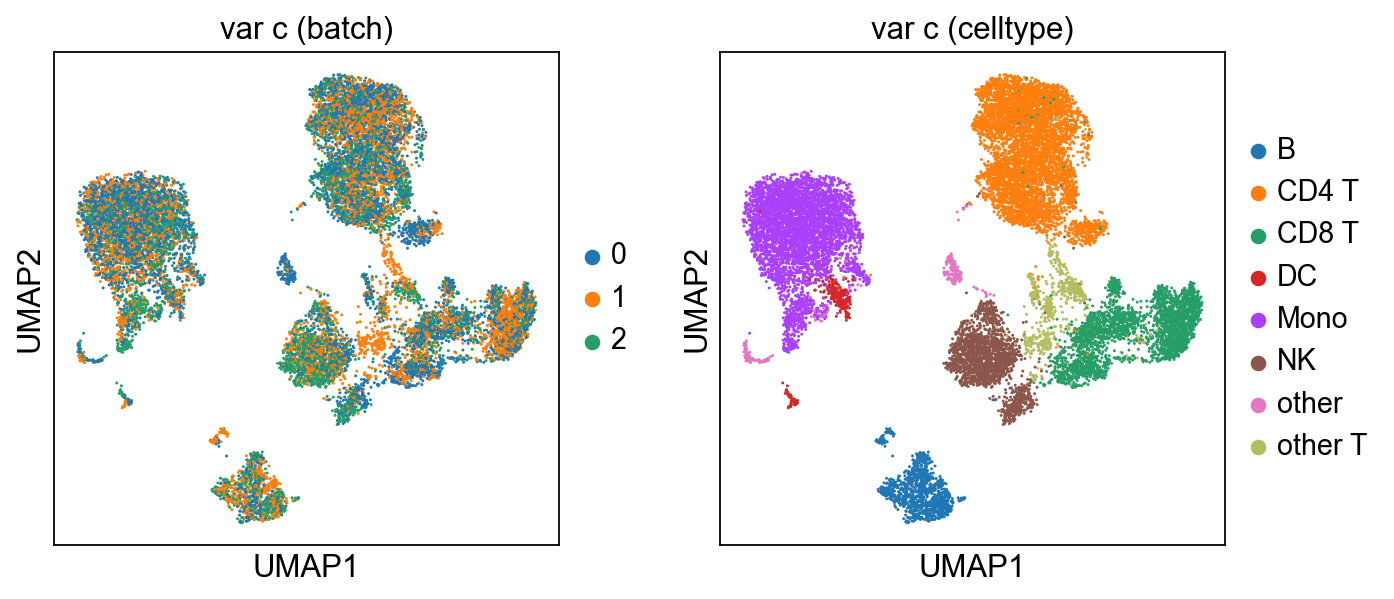

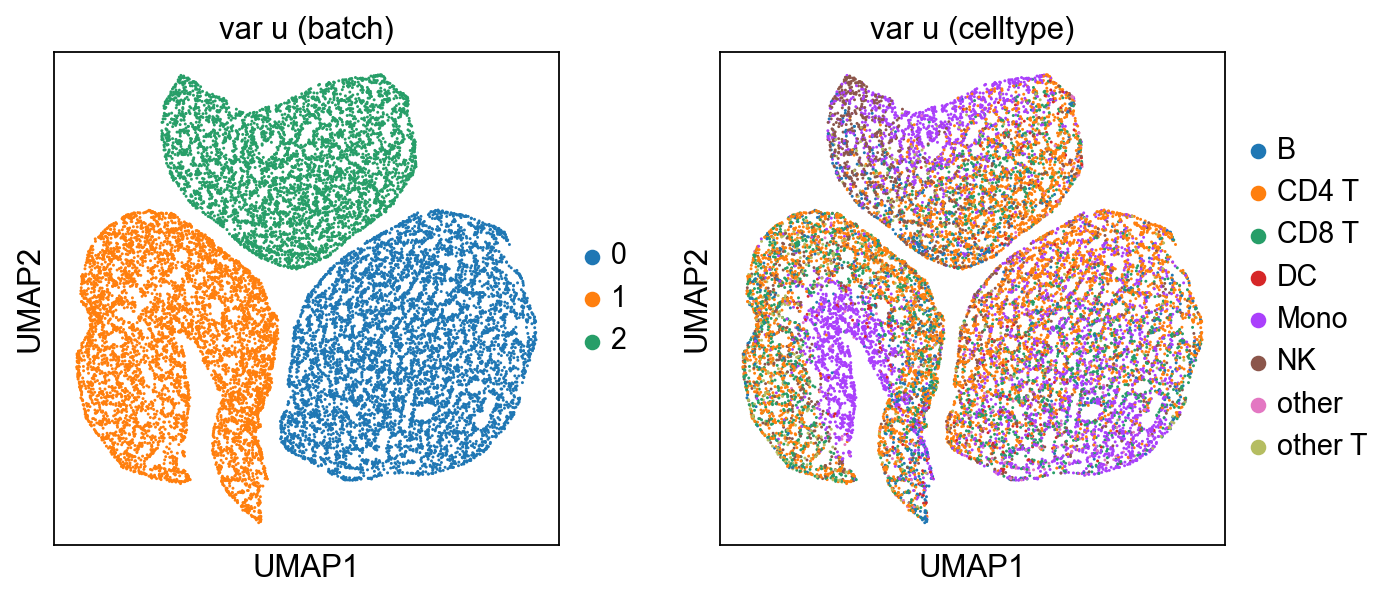

In [11]:
c = emb["z"]["joint"][:, :32] # biological information
b = emb["z"]["joint"][:, 32:] # batch information

adata = sc.AnnData(c)
adata2 = sc.AnnData(b)
adata.obs['batch'] = emb["s"]["joint"].astype('str')
adata2.obs['batch'] = emb["s"]["joint"].astype('str')
label = pd.concat([pd.read_csv(f'./data/raw/rna+adt/wnn/p1_0/label_seurat/l1.csv', index_col=0),
                   pd.read_csv(f'./data/raw/rna+adt/wnn/p2_0/label_seurat/l1.csv', index_col=0),
                   pd.read_csv(f'./data/raw/rna+adt/wnn/p3_0/label_seurat/l1.csv', index_col=0),
                   ])
adata.obs['label'] = label.values.flatten()
adata2.obs['label'] = label.values.flatten()

sc.pp.subsample(adata, fraction=1) # shuffle for better visualization
sc.pp.subsample(adata2, fraction=1)

sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)

sc.pl.umap(adata, color=['batch', 'label'], wspace=0.2, title=["var c (batch)", "var c (celltype)"])
sc.pl.umap(adata2, color=['batch', 'label'], wspace=0.2, title=["var u (batch)", "var u (celltype)"])

### Modality-specific Embeddings

In [12]:
model.predict(save_dir=f'./result/{task}/predict/', mod_latent=True)

Predicting ...
Removing directory "./result/wnn_demo/predict/subset_1/z"
Removing directory "./result/wnn_demo/predict/subset_2/z"
Removing directory "./result/wnn_demo/predict/subset_0/z"
Processing subset 0: ['rna', 'adt']


100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


Processing subset 1: ['rna']


100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


Processing subset 2: ['adt']


100%|██████████| 19/19 [00:06<00:00,  2.84it/s]


In [13]:
modality_emb = model.read_preds(joint_latent=True, mod_latent=True)

Loading predicted variables ...


100%|██████████| 19/19 [00:00<00:00, 307.27it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: s, rna
Converting subset 0: s, adt
Converting subset 0: z, joint
Converting subset 0: z, rna
Converting subset 0: z, adt
Converting subset 1: s, joint
Converting subset 1: s, rna
Converting subset 1: z, joint
Converting subset 1: z, rna
Converting subset 2: s, joint
Converting subset 2: s, adt
Converting subset 2: z, joint
Converting subset 2: z, adt


In [18]:
import scmidas.utils as utils

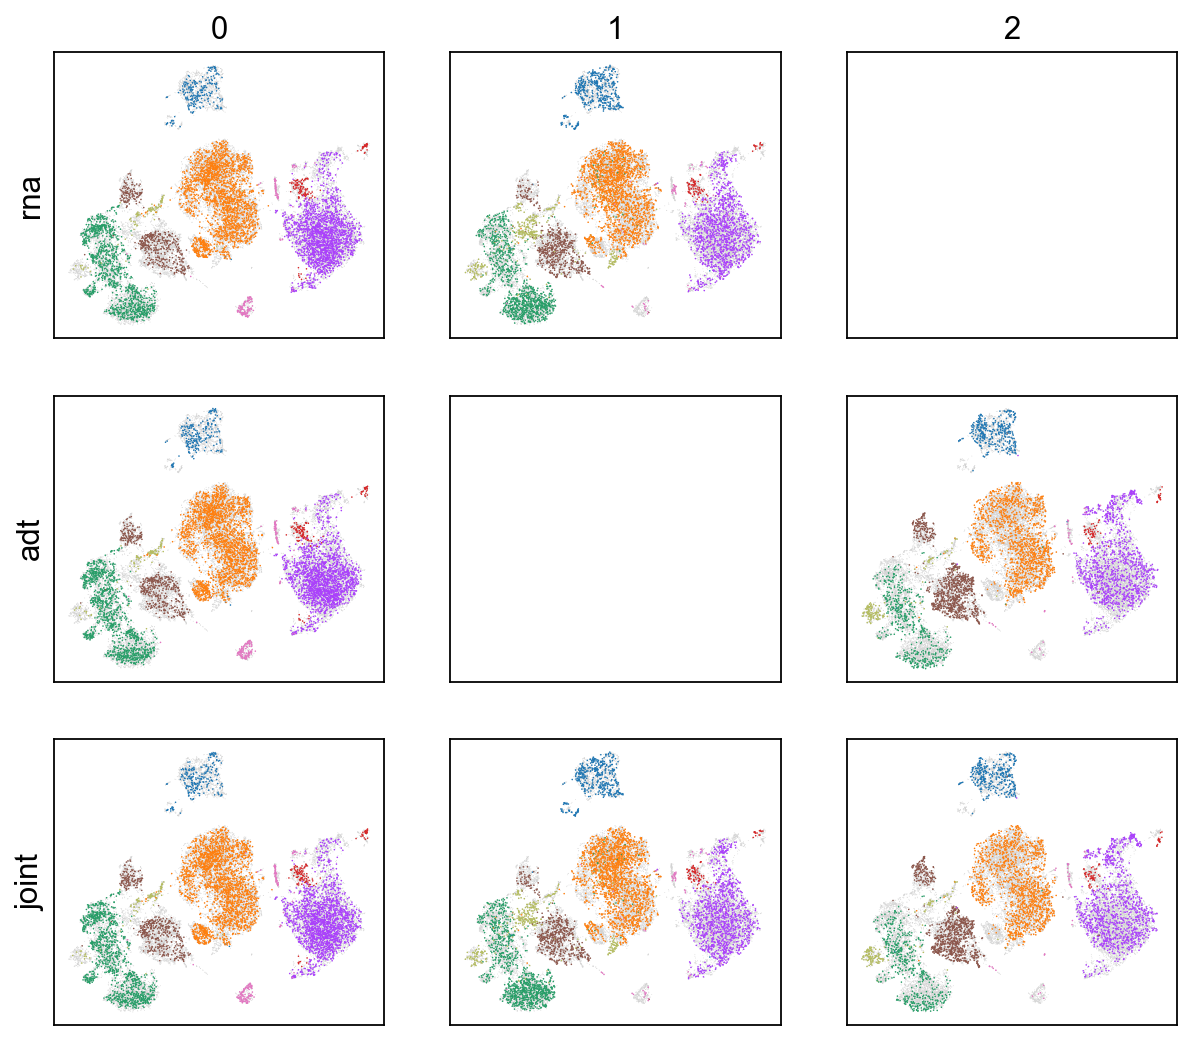

In [ ]:
label["s"] = modality_emb["s"]["joint"]
label.columns = ["x", "s"]
utils.viz_mod_latent(modality_emb, label, legend=False)